In [133]:
# Imports
import LinearAlgebra: I, diag
import Optimisers
import Zygote
import Random
import Plots
import Optim

using Distributions
using ApproximateGPs
using ParameterHandling

In [2]:
# Generate data
x = range(0, 1, 100)
y = cos.(x .* 2 .* pi) + randn(length(x)) .* x.^3
;

In [187]:
# Models and objective functions
jitter = 1e-6

function build_SVGP(params::NamedTuple)
    kernel = params.k.var * (SqExponentialKernel() ∘ ScaleTransform(params.k.precision))
    # kernel = SqExponentialKernel()
    f = LatentGP(GP(kernel), GaussianLikelihood(params.obs_var), jitter)
    q = MvNormal(params.m, params.A)
    fz = f(params.z).fx
    return SparseVariationalApproximation(fz, q), f
end

_prior_kl(sva::ApproximateGPs.SparseVariationalApproximation{Centered}) = kldivergence(sva.q, sva.fz)

function _prior_kl(sva::ApproximateGPs.SparseVariationalApproximation{NonCentered})
    m_ε = mean(sva.q)
    C_ε = ApproximateGPs._cov(sva.q)

    # trace_term = tr(C_ε)  # does not work due to PDMat / Zygote issues
    L = ApproximateGPs._chol_lower(ApproximateGPs._chol_cov(sva.q))
    trace_term = sum(L .^ 2)  # TODO remove AD workaround

    return (trace_term + m_ε'm_ε - length(m_ε) - ApproximateGPs.logdet(C_ε)) / 2
end

function loss(params::NamedTuple)
    svgp, f = build_SVGP(params)
    fx = f(x)
    return -_elbo(svgp, fx, y; quadrature=ApproximateGPs.GPLikelihoods.MonteCarloExpectation(100))
end;

function _elbo(
    sva::ApproximateGPs.SparseVariationalApproximation,
    lfx::ApproximateGPs.AbstractGPs.LatentFiniteGP,
    y::AbstractVector;
    num_data=length(y),
    quadrature=DefaultExpectationMethod())
    sva.fz.f === lfx.fx.f || throw(
        ArgumentError(
            "(Latent)FiniteGP prior is not consistent with SparseVariationalApproximation's",
        ),
    )

    f_post = posterior(sva)
    q_f = marginals(f_post(lfx.fx.x))
    variational_exp = _expected_loglikelihood(quadrature, lfx.lik, q_f, y)

    n_batch = length(y)
    scale = num_data / n_batch
    return sum(variational_exp) * scale - _prior_kl(sva)
end

function _expected_loglikelihood(
    mc::ApproximateGPs.GPLikelihoods.MonteCarloExpectation, lik, q_f::AbstractVector{<:Normal}, y::AbstractVector)
    # take `n_samples` reparameterised samples
    f_μ = mean.(q_f)
    fs = f_μ .+ std.(q_f) .* randn(eltype(f_μ), length(q_f), mc.n_samples)
    lls = loglikelihood.(lik.(fs), y)
    return sum(lls) / mc.n_samples
end

function loss_pll(params::NamedTuple)
    svgp, f = build_SVGP(params)
    fx = f(x)
    return -predictive_loglikelihood(svgp, fx, y)
end;

function predictive_loglikelihood(
    sva::ApproximateGPs.SparseVariationalApproximation, 
    lfx::ApproximateGPs.AbstractGPs.LatentFiniteGP,
    y::AbstractVector;
    num_data=length(y),
    quadrature=ApproximateGPs.GPLikelihoods.MonteCarloExpectation(100))
    
    sva.fz.f === lfx.fx.f || throw(
        ArgumentError(
            "(Latent)FiniteGP prior is not consistent with SparseVariationalApproximation's",
        ),
    )

    f_post = posterior(sva)
    q_f = marginals(f_post(lfx.fx.x))
    variational_exp = log_marginal(quadrature, lfx.lik, q_f, y)

    n_batch = length(y)
    scale = num_data / n_batch
    return sum(variational_exp) * scale - _prior_kl(sva)
end

_prior_kl(sva::ApproximateGPs.SparseVariationalApproximation{Centered}) = kldivergence(sva.q, sva.fz)

function _prior_kl(sva::ApproximateGPs.SparseVariationalApproximation{NonCentered})
    m_ε = mean(sva.q)
    C_ε = ApproximateGPs._cov(sva.q)

    # trace_term = tr(C_ε)  # does not work due to PDMat / Zygote issues
    L = ApproximateGPs._chol_lower(ApproximateGPs._chol_cov(sva.q))
    trace_term = sum(L .^ 2)  # TODO remove AD workaround

    return (trace_term + m_ε'm_ε - length(m_ε) - ApproximateGPs.logdet(C_ε)) / 2
end

function log_marginal(mc::ApproximateGPs.GPLikelihoods.MonteCarloExpectation, lik, q_f::AbstractVector{<:Normal}, y::AbstractVector)
    # take `n_samples` reparameterised samples
    f_μ = mean.(q_f)
    fs = f_μ .+ std.(q_f) .* randn(eltype(f_μ), length(q_f), mc.n_samples)
    lls = logpdf.(Normal.(fs, sqrt(lik.σ²[1])), y)
    return log.(sum(exp.(lls .- log(mc.n_samples)), dims=2))
end
;

In [179]:
# Train VariationalELBO model
M = 6  # number of inducing points
raw_initial_params = (
    k=(var=positive(rand()), precision=positive(rand())),
    z=bounded.(range(0.01, 0.99; length=M), 0.0, 1.0),  # constrain z to simplify optimisation
    m=zeros(M),
    A=positive_definite(Matrix{Float64}(I, M, M) .* 0.6932),
    obs_var=positive(0.6932)
);

flat_init_params, unflatten = ParameterHandling.flatten(raw_initial_params)
unpack = ParameterHandling.value ∘ unflatten;

opt = Optimisers.ADAM(0.1)
opt_state = Optimisers.setup(opt, flat_init_params)

for epoch in 1:50
    LL, back = Zygote.pullback(loss ∘ unpack, flat_init_params)
    if epoch == 1 || epoch % 5 == 0
        println("Epoch $epoch: LL = $LL")
    end
    grad = first(back(1.))
    opt_state, flat_init_params = Optimisers.update(opt_state, flat_init_params, grad)
end


Epoch 1: LL = 127.84695663245397
Epoch 5: LL = 124.25405064589044
Epoch 10: LL = 122.0296861653926
Epoch 15: LL = 116.90277384706823
Epoch 20: LL = 102.29861191118334
Epoch 25: LL = 82.1177295027898
Epoch 30: LL = 69.70327963432725
Epoch 35: LL = 69.80760328062946
Epoch 40: LL = 67.70322856234309
Epoch 45: LL = 67.29885496578368
Epoch 50: LL = 65.6803603027688


In [188]:
# Train PredictiveLogLikelihood model
M = 6  # number of inducing points
flat_init_params_pll, unflatten = ParameterHandling.flatten(raw_initial_params)
unpack = ParameterHandling.value ∘ unflatten;

opt_pll = Optimisers.ADAM(0.1)
opt_state_pll = Optimisers.setup(opt_pll, flat_init_params_pll)

for epoch in 1:50
    LL, back = Zygote.pullback(loss_pll ∘ unpack, flat_init_params_pll)
    if epoch == 1 || epoch % 5 == 0
        println("Epoch $epoch: LL = $LL")
    end
    grad = first(back(1.))
    opt_state_pll, flat_init_params_pll = Optimisers.update(opt_state_pll, flat_init_params_pll, grad)
end


Epoch 1: LL = 123.78550089381355
Epoch 5: LL = 121.38879744747734
Epoch 10: LL = 116.29943451533244
Epoch 15: LL = 98.72119584681485
Epoch 20: LL = 60.22184215906126
Epoch 25: LL = 36.20859135060033
Epoch 30: LL = 18.387655202494294
Epoch 35: LL = 3.1384232950832462
Epoch 40: LL = -9.687326400505501
Epoch 45: LL = -19.4628145780703
Epoch 50: LL = -25.05091193417955


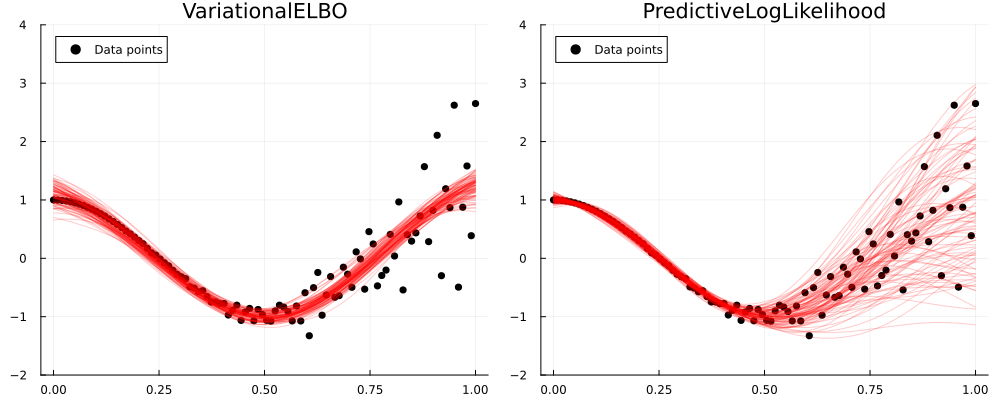

In [189]:
# Plot final model fits
# VariationalELBO
final_params = unpack(flat_init_params)
svgp_opt, f_opt = build_SVGP(final_params)
post_opt = posterior(svgp_opt)
l_post_opt = LatentGP(post_opt, GaussianLikelihood(final_params.obs_var), jitter)

post_f_samples = rand(l_post_opt.f(x, jitter), 100)
post_μ_samples = mean.(l_post_opt.lik.(post_f_samples))

lfx = f_opt(x)
f_post = posterior(svgp_opt)
q_f = marginals(f_post(lfx.fx.x))

plta = Plots.scatter(x, y; seriescolor="black", label="Data points", title="VariationalELBO")
Plots.plot!(plta, x, post_μ_samples; seriescolor="red", alpha=0.2, label="")

# PredictiveLogLikelihood
final_params = unpack(flat_init_params_pll)
svgp_opt, f_opt = build_SVGP(final_params)
post_opt = posterior(svgp_opt)
l_post_opt = LatentGP(post_opt, GaussianLikelihood(final_params.obs_var), jitter)

post_f_samples = rand(l_post_opt.f(x, jitter), 100)
post_μ_samples = mean.(l_post_opt.lik.(post_f_samples))

lfx = f_opt(x)
f_post = posterior(svgp_opt)
q_f = marginals(f_post(lfx.fx.x))

pltb = Plots.scatter(x, y; seriescolor="black", label="Data points", title="PredictiveLogLikelihood")
Plots.plot!(pltb, x, post_μ_samples; seriescolor="red", alpha=0.2, label="")

Plots.plot(plta, pltb, size=(1000, 400), ylim=(-2, 4))